# Prueba del método Class-Agnostic Counting
Este método se trata de una técnica basada en machine learning, en el cual, adiferencia de otros métodos que solo saben diferenciar entre instancias concretas, esta es capaz de ofrecer algo más general pasándole una imagen de ejemplo de una instancia (parche) y ser entrenada para cualquier tipo de objeto "Class-Agnostic". El resultado que nos devolverá el modelo Class-Agnostic Counting será una matriz que se podrá visualizar como una imagen de un mapa de calor en escala de grises. Dicho mapa de calor consistirá en gaussianas en las posiciones correspondientes a las instancias en la imagen procesada, las gaussianas serán más intensas o tenues dependiendo de lo bueno que sea el propio modelo y de lo bien que se distingan dichos objetos en la imagen original, siguiendo el principio de auto-similitud se detectarán parches auto-smilares (que pueden ser representados por ellos o partes de ellos mismos) hasta un cierto grado. Para estimar el conteo de las instancias de la imagen se contarán el número de picos de las gaussianas, esto es, por detección de máximos locales. Una detección ligeramente sensible debería ser capaz detectar la mayoría de ellas, incluidas las más tenues y las que están unidas, indicando un solapamiento de las instancias.

Class-Agnostic Counting propone de base un modelo genérico, generic matching network (GMN) de dos flujos o canales iniciales, siendo uno de estos flujos el de la imagen de ejemplo o parche y el otro el de la imagen completa que se le quiere hacer la busqueda de instancias (para su posterior conteo). El input (imágenes) de estos flujos es sometida a varias operaciones representadas como funciones, que consisten en general varias capas neuronales de convolución, normalización de batch, pooling, activación, etc, lo que acaba convirtiendo el parche de ejemplo en un vector de características y la imagen a analizar en un mapa de características. Dichas transformaciones son normalizadas con norma L2. Las dimensiones del vector de características son de $1\times1\times512$, teniendo en cuenta que las imágenes de entrada, tanto el parche como la imagen de busqueda, son reescaladas antes de introducirse en la red, el parche generalmente a $64\times64\times3$ (siendo la tercera dimensión la profundidad o los canales, imagen RGB por lo que tendrá 3 canales) y la imagen completa se reescala de acuerdo al valor de la *bounding box* $(H,W)$, y su mapa de características resultante de su flujo será de tamaño $H/8\times W/8\times512$. Para poder concatenar ambos flujos en uno el vector de características será extendido a las dimensiones del mapa de características. Una vez concatenados en un solo flujo, para obtener el mapa de calor resultante, a ese flujo se le aplicarán, como antes, unas operaciones representadas por otra función que consistirá en capas de pooling, normalización de batch, activación, convolución y convolución traspuesta. El mapa de calor de la salida de la red será de dimensiones $H/4\times W/4\times1$ con solo un canal de salida porque estará en escala de grises.

Esto que se ha explicado es la arquitectura detrás de la GMN que será entrenada con una gran cantidad de datos de video etiquetados (aprovechandose de las repeticiones que ocurren en cada frame). Si se quiere especializar la red a una instancia más concreta, puede que se quiera usar para algo más concreto como detección de células o algo más común, pero con características específicas como aves de color blanco,  existe el módulo de adaptación.

Este módulo en la arquitectura de la red consiste en añadir unos módulos de adaptación, que constan de varias redes convolucionales más, a las funciones de ambos flujos de la GMN (antes de concatenarse, cuando son dos flujos separados). La clave de esto está en que durante el entrenamiento de la adaptación, se parten de los pesos de la red genérica ya entrenados, y lo que se hará es especializar dichos pesos a una instancia concreta. Esto se realiza congelando todos los parámetros del modelo genérico y solo entrenando los módulos de adaptación mencionados antes y todas las capas de normalización de batch de la arquitectura de la GMN.

Enlaces de interes sobre Class-Agnostic Counting:
- Repositorio de Github con el código fuente para Class-Agnostic Counting: https://github.com/erikalu/class-agnostic-counting
- Artículo académico de Class-Agnostic Counting: https://arxiv.org/abs/1811.00472
- Enlace de la guía para descargar y procesar los datos de video para entrenar la GMN: https://github.com/bertinetto/siamese-fc/tree/master/ILSVRC15-curation

**Nota:** En el repositorio de Class-Agnostic Counting (primer enlace) está disponible para descargar los pesos de la GMN ya entrenados, por lo que no es necesario, si no se quiere, descargar el gran volumen de datos de video, procesarlos y entrenar la red.

Una vez explicado la arquitectura de Class-Agnostic Counting y teniendo clara su idea general, se puede proceder a realizar la demostración de ejemplo con células VGG y después la obtención de los resultados para diversas imágenes de bandadas de aves blancas, ambos usando el módulo de adaptación de la red a una clase de objetos específica.

Las librerías que se utilizarán en estos ejemplos.

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as imag
from PIL import Image
from skimage.feature import peak_local_max

## Prueba de células VGG
Para detectar con precisión las células de una imagen la red genérica deberá ser adaptada a un dataset de imágenes más concreto, de células VGG precisamente. para ello se necesita preparar lo siguiente.

El **conjunto de imágenes** de la clase de objeto a la que se quiere adaptar la red, que se usará para entrenarla, cada imagen de este dataset deberá estar **etiquetada**. Lo de etiqueta se refiere a unas imagenes asociadas a las reales con las mismas dimensiones, con el fondo negro y que donde se indique con un pixel de otro color (el código de Class-Agnostic Counting tiene en cuenta el rojo, peo se puede cambiar) la posición de cada instancia de elementos, en la imagen original. Esto se hace porque el código de Class-Agnostic Counting para entrenar genera gaussianas en 2D a partir de las imágenes de etiquetas, es decir, en cada pixel que indica la posición del elemento genera un gaussiana que luego usará para comprobar las predicciones con una función de perdidas MSE.
- El conjunto de imágenes de células VGG $(256\times256)$: http://www.robots.ox.ac.uk/~vgg/research/counting/index_org.html

Para que el código sepa que hacer con las imágenes hace falta generar varios arrays que indiquen qué imágenes son imágenes reales y se usarán para entrenamiento y cuales para validación (si se quiere usar validación) y lo mismo para las imágenes de etiquetas. Dichos arrays se guardarán todos en formato `.npz`. En este caso el ejemplo de células VGG era uno utilizado en el artículo académico de Class-Agnostic Counting, por lo que el código ya estaba preparado para este dataset incluyendo el archivo `.npz` en la carpeta `meta` del repositorio.

Un vistazo a los arrays dentro del archivo `vgg_cell.npz`.

In [2]:
vgg_npz = np.load("class-agnostic-counting-master/meta/vgg_cell.npz")
vgg_npz.files

['trn_lb', 'trn_lst', 'val_lst', 'val_lb']

In [3]:
vgg_npz["trn_lst"]

array(['001cell.png', '002cell.png', '003cell.png', '004cell.png',
       '005cell.png', '006cell.png', '007cell.png', '008cell.png',
       '009cell.png', '010cell.png', '011cell.png', '012cell.png',
       '013cell.png', '014cell.png', '015cell.png', '016cell.png',
       '017cell.png', '018cell.png', '019cell.png', '020cell.png',
       '021cell.png', '022cell.png', '023cell.png', '024cell.png',
       '025cell.png', '026cell.png', '027cell.png', '028cell.png',
       '029cell.png', '030cell.png', '031cell.png', '032cell.png',
       '033cell.png', '034cell.png', '035cell.png', '036cell.png',
       '037cell.png', '038cell.png', '039cell.png', '040cell.png',
       '041cell.png', '042cell.png', '043cell.png', '044cell.png',
       '045cell.png', '046cell.png', '047cell.png', '048cell.png',
       '049cell.png', '050cell.png', '051cell.png', '052cell.png',
       '053cell.png', '054cell.png', '055cell.png', '056cell.png',
       '057cell.png', '058cell.png', '059cell.png', '060cell.p

Los nombres con los que se identifican los arrays son los que el código de Class-Agnostic Counting está preparado para detectar, por lo que siempre se usarán esos. El array `trn_lb` contiene los nombres de las imágenes de etiquetas que se usarán para el entrenamiento, `trn_lst` las imágenes reales para entrenamiento, y `val_lb` y `val_lst` sus equivalentes para validación.

Otra cosa a tener en cuenta es que en el archivo Python donde se cargan los datos, `data_loader.py` en la carpeta `src` del proyecto Class-Agnostic Counting, es donde se define cierta información sobre la entrada de la red dependiendo del dataset, como el reescalado inicial que se hace al parche y a la imagen de busqueda que se comento cuando se explico la arquitectura al principio. En el caso de las células VGG el código ya venía preparado, por lo que no hay que crear nada nuevo, se puede ver una muestra del código.

```
elif self.dataset == 'vgg_cell':
    self.imgdims = (1024, 1024, 3)
    self.patchdims = (64, 64, 3)
    self.outputdims = (200, 200, 1)
    self.pad = 0
```

La *bounding box* que se menciono antes es `self.imgdims`, y aunque en el código original era de $800\times800$, es preferible usar una de $1024\times1024$ para que el mapa de calor resultante sea del mismo tamaño que la imagen $(256\times256)$, teniendo en cuenta que la salida de la red tiene unas dimensiones $H/4\times W/4\times1$, siendo $H$ y $W$ las dimensiones reescaladas de la imagen original por la *bounding box*. Contra más grande la *bounding box* más preciso será el mapa de calor, pero también será más costoso computacionalmente.

Con el siguiente comando se puede comenzar a adaptar la GMN al dataset de células VGG indicado: 

`python class-agnostic-counting-master/src/main.py --mode adapt --dataset vgg_cell --data_path data_VGG_Cells --gmn_path pretrained_gmn.h5 --gpu 0 --lr 0.0004 --batch_size 12 --epochs 72`

Los parámetros:
- `--dataset` el dataset que se cargará mediante `data_loader.py`.
- `--data_path` directorio del dataset.
- `--mode` para indicar el método que usaremos (adaptar, entrenar una GMN, testear, ...).
- `--gmn_path` archivo de los pesos de la GMN ya entrenada o adaptada en el caso de que se este probando. 
- `--lr` la tasa de aprendizaje.
- `--batch_size` el tamaño e los lotes de imágenes.
- `--epochs` número de épocas que se entrenará el modelo.
- `--gpu` indica que se use el procesador gráfico para operar con los tensores de la red, si se tiene una gráfica se pone `gpu 0`, si se tienen dos `gpu 0 1`, etc. Es muy recomendable usarla, porque utilizar y sobretodo entrenar esta red con la potencia del procesador va a llevar mucho tiempo. 

Por último es necesario un método de prueba en el código principal (`main.py` en la carpeta `src`) para cargar la red con sus pesos entrenados y adaptados, y procesar la imagen que se desee. Este método será una de las mayores modificaciones que se harán en el código de Class-Agnostic Counting, dado que el código original no provee ningún método de prueba.

```
def test_gmn_adapt():
    # ==> gpu configuration
    ut.initialize_GPU(args)

    # ==> set up model path and log path.
    model_path, log_path = ut.set_path(args)

    # ==> import library
    import keras
    import data_loader
    import model_factory
    import data_generator
    import scipy

    # ==> get dataset information
    trn_config = data_loader.get_config(args)

    params = {'cg': trn_config,
              'processes': 12,
              'batch_size': args.batch_size
              }

    trn_gen, val_gen = data_generator.setup_generator(**params)

    # ==> load networks
    model = model_factory.two_stream_matching_networks(trn_config, sync=False, adapt=True)

    # ==> attempt to load pre-trained GMN
    if args.gmn_path:
        if os.path.isfile(args.gmn_path):
            model.load_weights(os.path.join(args.gmn_path), by_name=True)
            print('==> successfully loading the model: {}'.format(args.gmn_path))
        else:
            print("==> no checkpoint found at '{}'".format(args.gmn_path))

    # ==> print model summary
    model.summary()

    inp_img = ut.load_data('data/VGGcell_112.png',dims=(1024,1024,3), pad=0)
    ex_patch = ut.load_data('data/VGGcell_patch.png',dims=(64,64,3), pad=0)

    inp_img = np.expand_dims(inp_img, axis=0)
    ex_patch = np.expand_dims(ex_patch, axis=0)
    inp_img = data_generator.preprocess_input(np.array(inp_img, dtype='float64'))
    ex_patch = data_generator.preprocess_input(np.array(ex_patch, dtype='float64'))

    inputs = {'image_patch': ex_patch, 'image': inp_img}
    output = model.predict(inputs, batch_size=1)
    # Se comprimen las dimensiones extra de tamaño 1 generadas por el modelo, de (1, 200, 200, 1) a (200, 200)
    output = np.squeeze(output, axis=0)
    output = np.squeeze(output, axis=2)
    np.save('data/MapaDensidad_VGGcell_112.npy', output)
```

Arriba se ve el código utilizado para procesar una imagen de dimensiones reducidas $256\times256$ con la red GMN adaptada, se renarca lo de dimensiones reducidas, porque para las imágenes de bandadas de aves que se procesarán más adelante las dimensiones serán mucho mayores por lo que habrá que diseñar un método de prueba que tenga eso en cuenta.

Este método básicamente crea la arquitectura de la red y carga en ella los pesos de la GMN adaptada a un dataset específico, también carga el parche y la imagen completa y las reescala a las dimensiones especificadas para ese dataset, se predice con el modelo con esas dos imágenes como entrada. La salida de la predicción se procesa para eliminar las dimensiones extra de tamaño 1 generadas durante el proceso y se guarda en formato `.npy` (array de numpy).

Para procesar una imagen con el modelo como se acaba de describir se usa el siguiente comando:

`python class-agnostic-counting-master/src/main.py --mode test_gmn_adapt --gmn_path model_adaptVGG.h5 --dataset vgg_cell --data_path data_VGG_Cells`

Para finalizar, se carga el array .npy generado como resultado de aplicar el modelo a la imagen deseada y el parche de ejemplo. A continuación se buscan los máximos locales, hay que tener en cuenta que para esto hay dos parámetros importantes a ajustar:
- `min_distance` mínimo número de píxeles que separán a los máximos.
- `threshold_rel` la intensidad mínima que debe tener un máximo para que se detecte (valor del pixel).

Dependiendo del mapa de densidad resultante a veces tendremos que tunear los parámetros un poco.

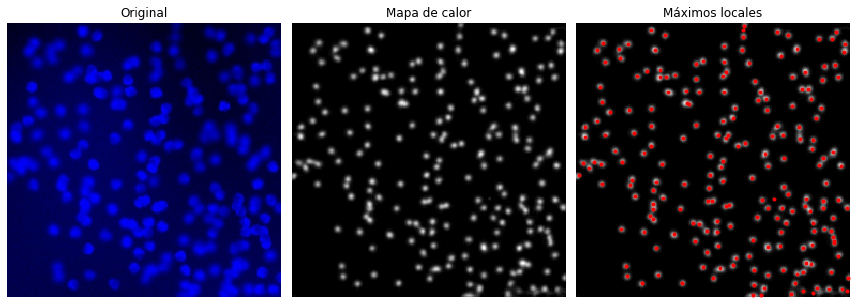

In [4]:
# Imagen resultante con mapa de calor
vggcell_dens = np.load("data/MapaDensidad_VGGcell_112.npy")
# Imagen original
vggcell_imgOrig1 = imag.imread("data/VGGcell_112.png")
# Información sobre la imagen, El número de píxeles distintos de 0 es el número real de elementos
vggcell_info = cv2.imread("data/VGGdots_112.png") 

coordinates = peak_local_max(vggcell_dens, min_distance = 1, threshold_rel = 0.1)

# display results
fig, axes = plt.subplots(1, 3, figsize=(12, 12), sharex = False, sharey = False)
ax = axes.ravel()
ax[0].imshow(vggcell_imgOrig1)
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(vggcell_dens, cmap = plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Mapa de calor')

ax[2].imshow(vggcell_dens, cmap=plt.cm.gray)
ax[2].autoscale(False)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[2].axis('off')
ax[2].set_title('Máximos locales')
fig.tight_layout()

plt.show()

Imagen del parche utilizado, junto con la imagen original, para generar el mapa de calor.

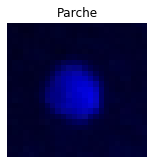

In [5]:
vggcell_parche = imag.imread("data/VGGcell_patch.png")

plt.figure(figsize = (2.5, 2.5))
plt.imshow(vggcell_parche)
plt.axis('off')
plt.title('Parche')
plt.show()

Aunque en el dataset de células VGG no se dispone de ningún archivo `CSV` adjunto a cada imagen para saber cuantas células hay en total, esta disponible el archivo de etiquetas, que indica con un pixel rojo la posición de cada célula en la imagen, por lo que solo hay que contar el número de píxeles en la imagen que no son cero (el fondo negro vale 0, que será toda la imagen excepto las posicones en las que se encuentren las células).

In [6]:
numero_cell = np.count_nonzero(vggcell_info)

print("El número real de células es", numero_cell)

El número real de células es 221


Compruebo la totalidad de los máximos locales obtenidos.

In [7]:
print("El número estimado de células mediante CAC es", coordinates.shape[0])

El número estimado de células mediante CAC es 206


Calculo el error como el valor absoluto de la diferencia entre la cantidad estimada y la cantidad real y lo divido por la cantidad real.

In [8]:
print("La estimación obtenida mediante CAC tiene un error del",
     (abs(coordinates.shape[0] - numero_cell)/numero_cell) * 100, "%")

La estimación obtenida mediante CAC tiene un error del 6.787330316742081 %


Un buen resultado para un modelo sencillo hecho para probar el método.

A continuación se probará con un modelo que ha adaptado para detectar aves de color blanco.

# Prueba del método CAC con las imágenes de Aves

Al igual que con las células VGG antes de empezar a procesar y analizar las imágenes hay que preparar la red y el código de Class-Agnostic Counting para este dataset.

Las imágenes de bandadas de aves blancas (gansos blancos) a las que se pretende adaptar la GMN pertenecen al dataset de **The Eastern Canada (ECA) Flocks**, que también contienen bandadas de aves marrones, pero en este trabajo solo se utilizarán las blancas. Este conjunto de imágenes se está usando en otra investigación por lo que tienen un embargo al público de 2 años y no se podrán subir las pruebas completas a un repositorio. En lo que respecta al dataset, se compone de imágenes que, a diferencia de las células VGG, estas no tienen unas dimensiones comúnes y de archivos CSV asociados a cada una de estas imágenes indicando la posición $X$ e $Y$ de cada ave en la imagen original y el tipo que son (blancas o marrones).

Para empezar con la adaptación se ve que falta uno de los elementos clave del entrenamiento, las imágenes asociadas de etiquetas (píxeles rojos en un fondo negro indicando la posición de las instancias), pero se dispone de los archivos CSV que tienen la suficiente información como para generar las etiquetas. Se ha desarrollado un pequeño programa en python para que a partir del directorio del dataset se recorra cada imagen y CSV asociado y genere una imagen de las mismas dimensiones con píxeles rojos en las posiciones indicadas en el CSV y fondo negro. En resumen, el archivo `generadorEtiquetas_ImagenesAves.py` genera las etiquetas para el dataset de ECA Flocks.

Ahora que ya se dispone de las etiquetas se necesita un archivo `.npz` que indique al código que imágenes y etiquetas serán para entrenamiento y cuales para validación, si se quiere usar, como ya se ha explicado en el caso de las células VGG. Aunque en este caso será algo más complicado porque las imágenes de bandadas tinen diferentes tamaños entre ellas y una dimensión bastante más grande que $256\times256$, por ejemplo, una no muy grande del dataset tiene unas dimensiones de $1233\times834$. Con estas dimensiones hacer el reescalado de la *bounding box* de $(1024\times1024)$ no será muy eficaz dado que en algunos casos las imágenes tendrán una dimensión mayor y entonces se estaría reduciendo su tamaño y tampoco se puede usar una *bounding box* mucho mayor debido a que el computador tiene una memoria de computo limitada (si es mucho más grande acabaría saltando un error de *Out of memory*). La solución encontrada a este problema es tratar con imágenes de $256\times256$ como con las células VGG, así al aplicar el reescalado inicial devolverá un mapa de calor también de $256\times256$. Por tanto las imágenes que se iban a usar de entrenamiento, junto con sus respectivas etiquetas se dividirán en bloques de $256\times256$, sin incluir los bloques sin instancias relevantes, es decir, imágenes sin aves. Las imágenes con las que se adaptará la GMN:
- GSGO_001_C Muchas aves, distribución complicada de las mismas, fondo no homogéneo. De las más complicadas del dataset.
- GSGO_008_C Pocas aves, con sombras y fondo en general homogéneo.
- GSGO_014_C Fondo no homogéneo y muchas aves.
- GSGO_018_C Fondo homogéneo pero muchas aves y algunas solapan.
- GSGO_019_C Fondo no homogéneo y pocas aves pero unas en vuelo y otras en tierra.
- GSGO_059_C Pocas aves, sin sombras y un fondo homogéneo en general excepto alguna zona.

Mediante el programa `generadorPedazosImagenes_ArchivoNPZ.py` se generará el nuevo dataset de entrenamiento de imágenes y etiquetas de aves blancas de tamaño $256\times256$ y se creará además el archivo `.npz` con los pedazos de $256\times256$ de las imágenes que se usarán para entrenar.

Un vistazo a los arrays dentro del archivo `aves.npz` que se ha generado con el programa python.

In [9]:
aves_npz = np.load("class-agnostic-counting-master/meta/aves.npz")
aves_npz.files

['trn_lb', 'trn_lst', 'val_lst', 'val_lb']

In [10]:
aves_npz["trn_lst"][0:29]

array(['GSGO_018_C_256x256-10.png', 'GSGO_018_C_256x256-100.png',
       'GSGO_018_C_256x256-101.png', 'GSGO_018_C_256x256-102.png',
       'GSGO_018_C_256x256-103.png', 'GSGO_018_C_256x256-105.png',
       'GSGO_018_C_256x256-106.png', 'GSGO_018_C_256x256-107.png',
       'GSGO_018_C_256x256-108.png', 'GSGO_018_C_256x256-109.png',
       'GSGO_018_C_256x256-11.png', 'GSGO_018_C_256x256-110.png',
       'GSGO_018_C_256x256-111.png', 'GSGO_018_C_256x256-112.png',
       'GSGO_018_C_256x256-113.png', 'GSGO_018_C_256x256-114.png',
       'GSGO_018_C_256x256-115.png', 'GSGO_018_C_256x256-116.png',
       'GSGO_018_C_256x256-117.png', 'GSGO_018_C_256x256-118.png',
       'GSGO_018_C_256x256-12.png', 'GSGO_018_C_256x256-120.png',
       'GSGO_018_C_256x256-121.png', 'GSGO_018_C_256x256-122.png',
       'GSGO_018_C_256x256-123.png', 'GSGO_018_C_256x256-124.png',
       'GSGO_018_C_256x256-125.png', 'GSGO_018_C_256x256-126.png',
       'GSGO_018_C_256x256-127.png'], dtype='<U26')

Tiene 609 imágenes de las que 479 se usan para entrenar. 

Por último, se modifica el archivo `data_loader.py` del método Class-Agnostic Counting para incluir el nuevo dataset de aves con cierta información como el reescalado del parche y la *bounding box*.

```
elif self.dataset == 'aves':
    self.imgdims = (1024, 1024, 3)
    self.patchdims = (64, 64, 3)
    self.outputdims = (256, 256, 1)
    self.pad = 0
```

Con esto ya se puede proceder a ejecutar el comando para adaptar la GMN al nuevo dataset de aves de $256\times256$.

`python class-agnostic-counting-master/src/main.py --mode adapt --dataset aves --data_path dataset_imagenes_aves_256x256 --gmn_path pretrained_gmn.h5 --gpu 0 --lr 0.0004 --batch_size 12 --epochs 72`

Los mismos parámetros que los explicados para el ejemplo de células VGG.

Por último, antes de poder ejecutar el código para procesar una imagen completa de una bandada de aves, es necesario otra modificación en el archivo del código principal `main.py` para añadir otro método de testeo que además solucione el problema de la gran dimensionalidad de la imagen a procesar.

```
def test_gmn_adapt_FullImg():
    ##########################################################
    ####### Comienzo inicialización
    ##########################################################
    # ==> gpu configuration
    ut.initialize_GPU(args)

    # ==> set up model path and log path.
    model_path, log_path = ut.set_path(args)

    # ==> import library
    import keras
    import data_loader
    import model_factory
    import data_generator
    import scipy
    
    from PIL import Image
    from skimage.transform import resize

    # ==> get dataset information
    trn_config = data_loader.get_config(args)

    params = {'cg': trn_config,
              'processes': 4, # Estaba en doce, cambiado para usarlo con ordenador personal (CPU)
              'batch_size': args.batch_size
              }

    trn_gen, val_gen = data_generator.setup_generator(**params)

    # ==> load networks
    model = model_factory.two_stream_matching_networks(trn_config, sync=False, adapt=True)

    # ==> attempt to load pre-trained GMN
    if args.gmn_path:
        if os.path.isfile(args.gmn_path):
            model.load_weights(os.path.join(args.gmn_path), by_name=True)
            print('==> successfully loading the model: {}'.format(args.gmn_path))
        else:
            print("==> no checkpoint found at '{}'".format(args.gmn_path))

    # ==> print model summary
    model.summary()
    ##########################################################
    ####### Fin inicialización
    ##########################################################
    
    # Cargo imagen completa
    im_aves = Image.open('data/GSGO_059_C.JPG')
    # Obtengo las dimensiones de la imagen
    imgwidth, imgheight = im_aves.size
    
    dims_img_orig = (imgheight, imgwidth)
    # Creo la imagen negra (ceros) en la que montaré los mapas de calor resultantes de procesar las imagenes 256x256 y obtendré el mapa de calor de la imagen original
    mapa_Calor = np.zeros(dims_img_orig)
    
    width, height = (256, 256) # Quiero imagenes de 256x256 para procesar
    
    overlap = 32 # 32 pixeles de solapamiento (16 para una imagen y 16 para otra), debe ser par para la división de la frontera de solpamiento entre las dos imágenes.
    
    # Cargo y proceso el parche para su uso
    ex_patch = ut.load_data('data/Ave_Patch.png',dims=(64,64,3), pad=0)
    ex_patch = np.expand_dims(ex_patch, axis=0)
    ex_patch = data_generator.preprocess_input(np.array(ex_patch, dtype='float64'))
    
    box = (0, 0, 256, 256)
    
    for i in range(0, imgheight, height - overlap): # anchura, primera dimensión, horizontal
        for j in range(0, imgwidth, width - overlap): # altura, segunda dimensión, vertical
            # Variables de control de los bordes izquierdo y superior
            ceroIzq_ceroArriba = False
            valorIzq_ceroArriba = False
            ceroIzq_valorArriba = False
            valorIzq_valorArriba = False
            if i == 0 and j == 0:
                ceroIzq_ceroArriba = True
            elif i != 0 and j == 0:
                valorIzq_ceroArriba = True
            elif i == 0 and j != 0:
                ceroIzq_valorArriba = True
            else:
                valorIzq_valorArriba = True
            box = (j, i, j + width, i + height)
            a = im_aves.crop(box)
            img = np.array(a)
            # redimensionar la imagen 256x256 a 1024x1024 que es con la que el modelo se ha entrenado
            imgdims = (1024, 1024, 3)
            img = resize(img, (imgdims[0], imgdims[1]))
            
            inp_img = np.expand_dims(img, axis=0)
            inp_img = data_generator.preprocess_input(np.array(inp_img, dtype='float64'))
            inputs = {'image_patch': ex_patch, 'image': inp_img}
            output = model.predict(inputs, batch_size=1) # Obtengo el mapa de calor del pedazo de imagen 256x256
            
            output = np.squeeze(output, axis=0)
            output = np.squeeze(output, axis=2)
            
            limit = list(output.shape)
            #Reconstrucción de los distintos mapas de calor en un mapa de calor respresentativo de la imagen completa
            if ceroIzq_ceroArriba:
                mapa_Calor[i:(i + width), j:(j + width)] = output
            elif valorIzq_ceroArriba:
                if mapa_Calor[(i+(overlap//2)):(i + width), j:(j + width)].shape[0] != 240:
                    limit[0] = mapa_Calor[(i+(overlap//2)):(i + width), j:(j + width)].shape[0] + (overlap//2)
                mapa_Calor[(i+(overlap//2)):(i + width), j:(j + width)] = output[(overlap//2):limit[0],:]
            elif ceroIzq_valorArriba:
                if mapa_Calor[i:(i + width), (j+(overlap//2)):(j + width)].shape[1] != 240:
                    limit[1] = mapa_Calor[i:(i + width), (j+(overlap//2)):(j + width)].shape[1] + (overlap//2) ## Sumerle el ovelap al final será necesario¿?¿?¿
                mapa_Calor[i:(i + width), (j+(overlap//2)):(j + width)] = output[:,(overlap//2):limit[1]]
            elif valorIzq_valorArriba:
                if mapa_Calor[(i+(overlap//2)):(i + width), (j+(overlap//2)):(j + width)].shape[0] != 240 ormapa_Calor[(i+(overlap//2)):(i + width), (j+(overlap//2)):(j + width)].shape[1] != 240:
                    limit[0] = mapa_Calor[(i+(overlap//2)):(i + width), (j+(overlap//2)):(j + width)].shape[0] + (overlap//2)
                    limit[1] = mapa_Calor[(i+(overlap//2)):(i + width), (j+(overlap//2)):(j + width)].shape[1] + (overlap//2)
                mapa_Calor[(i+(overlap//2)):(i + width), (j+(overlap//2)):(j + width)] = output[(overlap//2):limit[0],(overlap//2):limit[1]]
    
    # Cargo imagen inicial completa
    np.save('data/MapaDensidad_GSGO_059_C', mapa_Calor)
```

La base del problema es el mismo que el de recortar las imágenes en pedazos de $256\times256$, pero aquí no se quieren para entrenar, se quieren para obtener el mapa de calor del mismo tamaño que la imagen completa, por lo que habrá que reconstruir los pedazos para formar el mapa de calor completo con las dimensiones de la imagen original. La idea es separar la imagen en pedazos de $256\times256$, reescalar cada pedazo a la *bounding box* de $1024\times1024$ y aplicarle la red GMN adaptada obteniendo como resultado un mapa de calor equivalente al pedazo original de $256\times256$ (la red GMN tiene una salida de altura y anchura cuatro veces más pequeña) y construir un mapa de calor de las mismas dimensiones que la imagen completa.

Al hacer esto surge otro problema, en la división si un ave se corta en el borde entre dos pedazos el mapa de calor resultante de ambos trozos probablemente sean dos gaussianas tenues en el borde y al reconstruirlos quedarán como dos gaussianas tenues contiguas, lo que podría dar dos deteccines al contarlas cuando solo es una.

La solución propuesta a este problema es tener en cuenta un solapamiento en la división de los pedazos y en la reconstrucción de los mismos. El enfoque con solapamiento funciona de manera que se van cogiendo bloques de $256\times256$, pero cuando se avance al siguiente bloque en vez de avanzar los índices de los píxeles en 256 (en anchura como altura, dependiendo de su posición) se avanza en 256 menos el solapamiento que en este caso será 32 píxeles de solapamiento (debe ser par para poder hacer la división de la frontera correctamente). Entonces al montar los pedazos, el nuevo pedazo se montará con un desplazamiento (de altura o de anchura o de ambas dependiendo de su posición) de la mitad del solapamiento (16 píxeles), esto producirá que no se tengan en cuenta los 16 píxeles de los bordes conflictivos de los bloques y así evitar que surgan dobles gaussianas erroneas en el mapa de calor completo.

Una vez solucionado el problema y entendido el método que se ejecutará, se puede empezar a generar los mapas de calor con el siguiente comando:

`python class-agnostic-counting-master/src/main.py --mode test_gmn_adapt_FullImg --gmn_path modelAves1024_Patch64_lr0.05_batchS12_Adam0.001_Epochs72.h5 --dataset aves --data_path dataset_imagenes_aves_256x256`

Ya está todo listo para poder obtener los resultados de las imágenes de las bandadas de aves como se ha hecho con el ejemplo de la células VGG.

**Atención:** Como ya se ha comentado las imágenes tienen un embargo, por lo que no se podrán ver los resultados con las imágenes de las bandadas de aves en el repositorio público.

## Conclusión Class-Agnostic Counting
El método Class-Agnostic Counting es una técnica basada en aprendizaje automático que ofrece un gran rendimiento cuando se adapta su red genérica a un dataset en específico. En las pruebas realizadas se han obtenido resultados bastante buenos, fallando generalmente cuando se produce una superposición de varias aves y cuando algún elemento del fondo influencia demasiado a la red y aparece una mancha no deseada en el mapa de calor. Sin manchas tiene un rango de error de entre el 0-8% observando menos error cuantas más instancias (aves) aparecen en la imagen, dado que la diferencia entre la estimación y el valor real se hace más evidente con valores más pequeños.

Destacar que el modelo solo ha sido entrenado con aves de color blanco, por lo que es probable que esté sesgado al color blanco y quiza por eso cuando el fondo tiene ciertas tonalidades blancas influencia a la red produciendo una mancha de falsos positivos. Sería interesante ver si las manchas se siguen produciendo usando aves de otros colores para el entrenamiento.

Otra cosa a tener en cuenta es que no se llega a automatizar del todo el método, dado que todavía se hace algún pequeño ajuste a los parámetros `min_distance` y `threshold_rel` dependiendo de la imagen. Son procesados manuales bastante más reducidos de los que se hacen con watershed, pero todavía se podría automatizar más. Para ello habría que hacer un método GridSearch al que se le pasarían una lista de valores para los dos parámetros y se probaría la estimación de elementos con cada pareja de valores devolviendo la que produzca el error más pequeño en más imágenes.

En general Class-Agnostic Counting es una técnica que ha producido buenos resultados y que una vez se le dedica el tiempo a adaptar la red el procesado de la imagen para obtener el mapa de calor es muy rápido, usando una GPU potente es casi instantaneo.
## Información de la sesión

In [40]:
import sys
sys.version

'3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]'

In [41]:
!pip freeze

absl-py==0.9.0
asn1crypto==1.3.0
astor==0.8.1
attrs==19.3.0
backcall==0.1.0
beautifulsoup4==4.8.2
bleach==3.1.0
blinker==1.4
bs4==0.0.1
cachetools==4.0.0
certifi==2020.4.5.2
cffi==1.14.0
cftime==1.1.1.1
chardet==3.0.4
click==7.1.1
colorama==0.4.3
conda==4.8.3
conda-package-handling==1.6.0
cryptography==2.8
cycler==0.10.0
decorator==4.4.2
defusedxml==0.6.0
entrypoints==0.3
Faker==3.0.0
gast==0.2.2
gastrodon==0.9.3
google-auth==1.11.2
google-auth-oauthlib==0.4.1
google-pasta==0.2.0
grpcio==1.27.2
h5py==2.10.0
idna==2.9
imageio==2.8.0
importlib-metadata==1.5.0
imutils==0.5.3
ipykernel==5.1.4
ipython==7.13.0
ipython-autotime==0.1
ipython-genutils==0.2.0
ipywidgets==7.5.1
isodate==0.6.0
jedi==0.16.0
Jinja2==2.11.1
joblib==0.14.1
jsonschema==3.2.0
jupyter==1.0.0
jupyter-client==6.1.0
jupyter-console==6.1.0
jupyter-core==4.6.1
kaggle==1.5.6
Keras==2.3.1
Keras-Applications==1.0.8
keras-contrib==2.0.8
Keras-Preprocessing==1.1.0
kiwisolver==1.1.0
lxml==4.5.0
Markdown==3.2.1
MarkupSafe==1.1.1
mat